# 1 - Data Preperation


### Mount Google Drive and Unzip Dataset


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Skin-Cancer-Detection/data/binary_classification/binary_classification.zip" -d "/content/binary_classification"

### Import Required Libraries


In [ ]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.utils import register_keras_serializable
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121, Xception
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

### Set Seed for Reproducibility


In [4]:
SEED = 55
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

### Load and Explore the Balanced Dataset


In [5]:
df = pd.read_csv('/content/binary_classification/binary_classification.csv')
df

,image_name,diagnosis,benign_malignant,target,path
0,ISIC_0056636,bkl,benign,0,data/ISIC_2019/train/ISIC_0056636.jpg
1,ISIC_0071013,bkl,benign,0,data/ISIC_2019/train/ISIC_0071013.jpg
2,ISIC_0073060,bkl,benign,0,data/ISIC_2019/train/ISIC_0073060.jpg
3,ISIC_0060602,bcc,malignant,1,data/ISIC_2019/train/ISIC_0060602.jpg
4,ISIC_0031624,bkl,benign,0,data/ISIC_2019/train/ISIC_0031624.jpg
...,...,...,...,...,...
6227,ISIC_0031570,scc,malignant,1,data/ISIC_2019/train/ISIC_0031570.jpg
6228,ISIC_0028623,bkl,benign,0,data/ISIC_2019/train/ISIC_0028623.jpg
6229,ISIC_0060798,bcc,malignant,1,data/ISIC_2019/train/ISIC_0060798.jpg
6230,ISIC_0028719,bcc,malignant,1,data/ISIC_2019/train/ISIC_0028719.jpg


#### Distribution


In [6]:
df['benign_malignant'].value_counts()

,count
benign_malignant,
benign,3116
malignant,3116


In [7]:
df['target'].value_counts()

,count
target,
0,3116
1,3116


### Split Data into Train, Validation and Test Sets


In [8]:
X = df[['image_name', 'path']]
y = df['benign_malignant']

In [9]:
X

,image_name,path
0,ISIC_0056636,data/ISIC_2019/train/ISIC_0056636.jpg
1,ISIC_0071013,data/ISIC_2019/train/ISIC_0071013.jpg
2,ISIC_0073060,data/ISIC_2019/train/ISIC_0073060.jpg
3,ISIC_0060602,data/ISIC_2019/train/ISIC_0060602.jpg
4,ISIC_0031624,data/ISIC_2019/train/ISIC_0031624.jpg
...,...,...
6227,ISIC_0031570,data/ISIC_2019/train/ISIC_0031570.jpg
6228,ISIC_0028623,data/ISIC_2019/train/ISIC_0028623.jpg
6229,ISIC_0060798,data/ISIC_2019/train/ISIC_0060798.jpg
6230,ISIC_0028719,data/ISIC_2019/train/ISIC_0028719.jpg


In [10]:
y

,benign_malignant
0,benign
1,benign
2,benign
3,malignant
4,benign
...,...
6227,malignant
6228,benign
6229,malignant
6230,malignant


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

#### Display Class Distribution in Train, Validation, and Test Sets


In [12]:
df_train = pd.concat([X_train, y_train], axis=1)
print("Train:", df_train['benign_malignant'].value_counts().to_dict())

Train: {'benign': 2243, 'malignant': 2243}


In [13]:
df_val = pd.concat([X_val, y_val], axis=1)
print("Validation:", df_val['benign_malignant'].value_counts().to_dict())

Validation: {'malignant': 561, 'benign': 561}


In [14]:
df_test = pd.concat([X_test, y_test], axis=1)
print("Test:", df_test['benign_malignant'].value_counts().to_dict())

Test: {'malignant': 312, 'benign': 312}


### Update Image Paths for Google Colab Environment


In [15]:
NEW_ROOT = "/content/binary_classification/binary_images"

df_train['path'] = df_train['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_val['path'] = df_val['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))
df_test['path'] = df_test['path'].apply(
    lambda x: os.path.join(NEW_ROOT, os.path.basename(x)))

In [16]:
df_train

,image_name,path,benign_malignant
5709,ISIC_0064115,/content/binary_classification/binary_images/I...,benign
861,ISIC_0060161,/content/binary_classification/binary_images/I...,benign
5043,ISIC_0070490,/content/binary_classification/binary_images/I...,malignant
5057,ISIC_0057497,/content/binary_classification/binary_images/I...,benign
1780,ISIC_0072359,/content/binary_classification/binary_images/I...,malignant
...,...,...,...
1822,ISIC_0063923,/content/binary_classification/binary_images/I...,malignant
4786,ISIC_0056605,/content/binary_classification/binary_images/I...,malignant
2315,ISIC_0027700,/content/binary_classification/binary_images/I...,malignant
1584,ISIC_0033626,/content/binary_classification/binary_images/I...,benign


In [17]:
df_val

,image_name,path,benign_malignant
2936,ISIC_0061157,/content/binary_classification/binary_images/I...,malignant
1782,ISIC_0073247,/content/binary_classification/binary_images/I...,malignant
1859,ISIC_0029161,/content/binary_classification/binary_images/I...,benign
1658,ISIC_0032804,/content/binary_classification/binary_images/I...,benign
3248,ISIC_0027435,/content/binary_classification/binary_images/I...,benign
...,...,...,...
711,ISIC_0055392,/content/binary_classification/binary_images/I...,malignant
6011,ISIC_0029288,/content/binary_classification/binary_images/I...,benign
2475,ISIC_0070421,/content/binary_classification/binary_images/I...,malignant
254,ISIC_0033248,/content/binary_classification/binary_images/I...,malignant


In [18]:
df_test

,image_name,path,benign_malignant
619,ISIC_0063506,/content/binary_classification/binary_images/I...,malignant
5304,ISIC_0056903,/content/binary_classification/binary_images/I...,benign
6045,ISIC_0012790_downsampled,/content/binary_classification/binary_images/I...,benign
1937,ISIC_0053562,/content/binary_classification/binary_images/I...,benign
2140,ISIC_0031198,/content/binary_classification/binary_images/I...,malignant
...,...,...,...
107,ISIC_0062951,/content/binary_classification/binary_images/I...,malignant
1637,ISIC_0058856,/content/binary_classification/binary_images/I...,benign
1638,ISIC_0069843,/content/binary_classification/binary_images/I...,malignant
1844,ISIC_0027046,/content/binary_classification/binary_images/I...,malignant


## Define Helper Function


### Visualize Training Metrics


In [19]:
def visualize_modeling_results(results):
    history = results.history
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### Visualize Confusion Matrix


In [20]:
def plot_confusion_matrices_only(model, data_generator, class_labels=['Benign', 'Malignant'], title_suffix=''):
    y_pred_probs = model.predict(data_generator)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
    y_true = data_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.show()

    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    disp_norm = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm, display_labels=class_labels)
    disp_norm.plot(cmap='Greens')
    plt.title(f"Normalized Confusion Matrix {title_suffix}")
    plt.show()

### Evaluate Model to Dataframe


In [21]:
def evaluate_model_to_dataframe(model, train_gen, val_gen, metric_names=None):
    train_results = model.evaluate(train_gen, verbose=0)
    val_results = model.evaluate(val_gen, verbose=0)

    if metric_names is None:
        metric_names = model.metrics_names
    metric_names = [name.capitalize() if name !=
                    'loss' else 'Loss' for name in metric_names]

    results_df = pd.DataFrame(columns=metric_names, index=[
                              'Train', 'Validation'])
    results_df.loc['Train'] = train_results[:len(metric_names)]
    results_df.loc['Validation'] = val_results[:len(metric_names)]

    return results_df

### Save Model and Results


In [22]:
def save_model_and_results(model, model_name, model_dir, local_path, results_df=None):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(local_path, exist_ok=True)

    model.save(os.path.join(model_dir, f"{model_name}.keras"))
    model.save(os.path.join(local_path, f"{model_name}.keras"))

    if results_df is not None:
        results_path = os.path.join(model_dir, f"{model_name}_results.csv")
        results_df.to_csv(results_path, index=False)

    print(f"Saved model to: {model_dir} and {local_path}")
    if results_df is not None:
        print(f"Saved results CSV to: {results_path}")

### Evaluate on Test Dataset


In [23]:
def evaluate_on_test_set(model, data_generator, class_labels=['Benign', 'Malignant'], title='Confusion Matrix - Test Set'):
    y_pred_probs = model.predict(data_generator, verbose=1)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    y_true = data_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# 2 - Model Training


## CNN


### Generate Data


In [ ]:
import gc

import tensorflow as tf
import torch

In [ ]:
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    shear_range=0.20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='binary'
)

Found 4486 validated image filenames belonging to 2 classes.
Found 1122 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


### Custom-CNN


In [ ]:
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same',
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)  # !

model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=loss_fn,
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint('cnn_model.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - AUC: 0.6042 - Precision: 0.5607 - Recall: 0.7442 - accuracy: 0.5704 - loss: 1.1419
Epoch 1: val_loss improved from inf to 1.08328, saving model to cnn_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 98s 591ms/step - AUC: 0.6046 - Precision: 0.5610 - Recall: 0.7439 - accuracy: 0.5707 - loss: 1.1414 - val_AUC: 0.5893 - val_Precision: 0.5051 - val_Recall: 0.9679 - val_accuracy: 0.5098 - val_loss: 1.0833 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - AUC: 0.7203 - Precision: 0.6475 - Recall: 0.6674 - accuracy: 0.6521 - loss: 1.0125
Epoch 2: val_loss did not improve from 1.08328
141/141 ━━━━━━━━━━━━━━━━━━━━ 65s 463ms/step - AUC: 0.7203 - Precision: 0.6475 - Recall: 0.6674 - accuracy: 0.6521 - loss: 1.0125 - val_AUC: 0.6431 - val_Precision: 0.5022 - val_Recall: 0.9964 - val_accuracy: 0.5045 - val_loss: 1.1376 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - AUC: 0.7507 - Precis

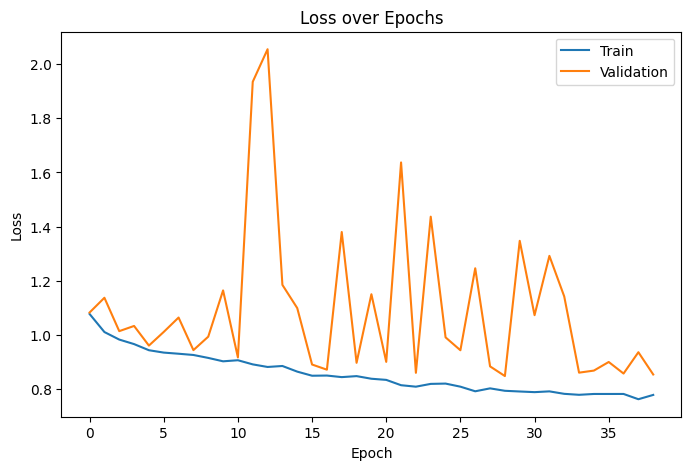

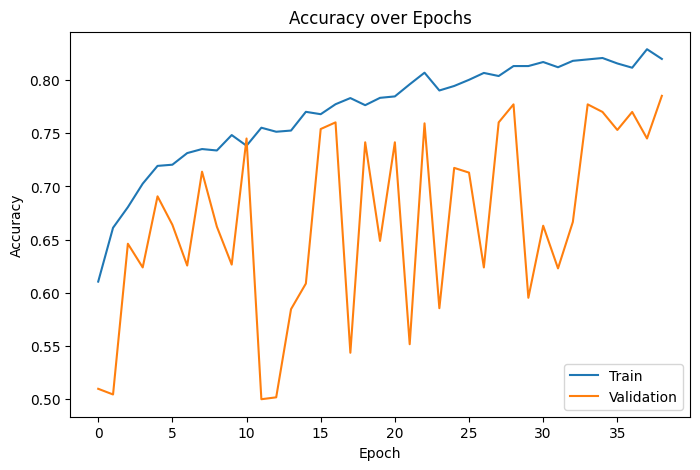

In [ ]:
visualize_modeling_results(model_history)

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step


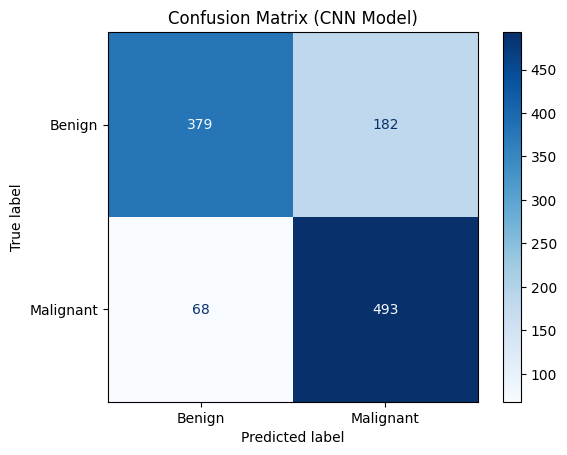

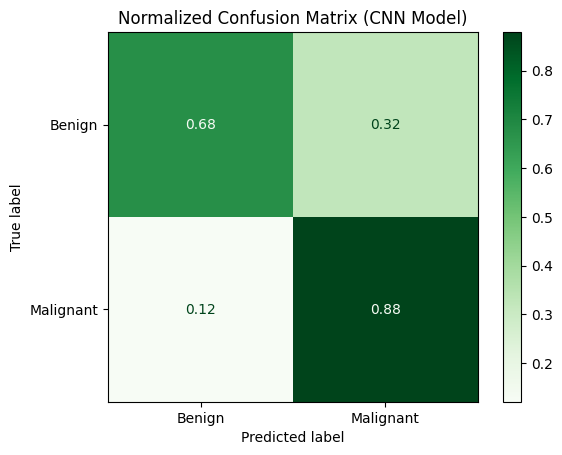

In [ ]:
plot_confusion_matrices_only(model, val_generator, title_suffix='(CNN Model)')

In [ ]:
model_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_results)

,Loss,Compile_metrics
Train,0.843809,0.777307
Validation,0.848873,0.777184


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_model_results.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.71      0.78       312
   Malignant       0.75      0.88      0.81       312

    accuracy                           0.80       624
   macro avg       0.81      0.80      0.79       624
weighted avg       0.81      0.80      0.79       624



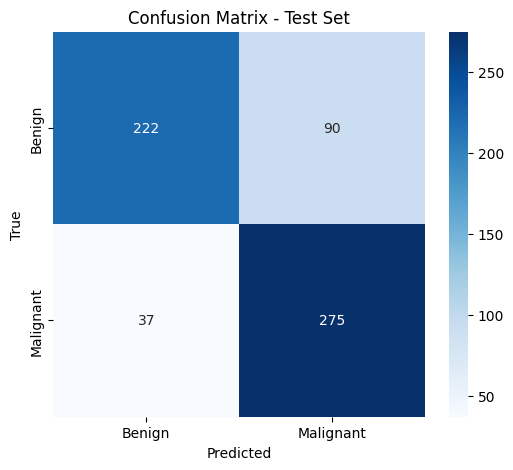

In [ ]:
model = load_model('cnn_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
model.load_weights('/content/cnn_model.keras')

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint('cnn_finetuned.keras',
                    save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - AUC: 0.8903 - Precision: 0.7875 - Recall: 0.8284 - accuracy: 0.8069 - loss: 0.7922
Epoch 1: val_loss improved from inf to 1.21330, saving model to cnn_finetuned.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 502ms/step - AUC: 0.8903 - Precision: 0.7876 - Recall: 0.8284 - accuracy: 0.8070 - loss: 0.7922 - val_AUC: 0.8167 - val_Precision: 0.8531 - val_Recall: 0.3725 - val_accuracy: 0.6542 - val_loss: 1.2133 - learning_rate: 1.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - AUC: 0.8950 - Precision: 0.7898 - Recall: 0.8586 - accuracy: 0.8167 - loss: 0.7871
Epoch 2: val_loss improved from 1.21330 to 0.83313, saving model to cnn_finetuned.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 64s 456ms/step - AUC: 0.8949 - Precision: 0.7898 - Recall: 0.8585 - accuracy: 0.8167 - loss: 0.7872 - val_AUC: 0.8669 - val_Precision: 0.7909 - val_Recall: 0.8093 - val_accuracy: 0.7977 - val_loss: 0.8331 - learning_rate: 1.0000e-04
Epoch 3/50
141/141 ━━━━━━━

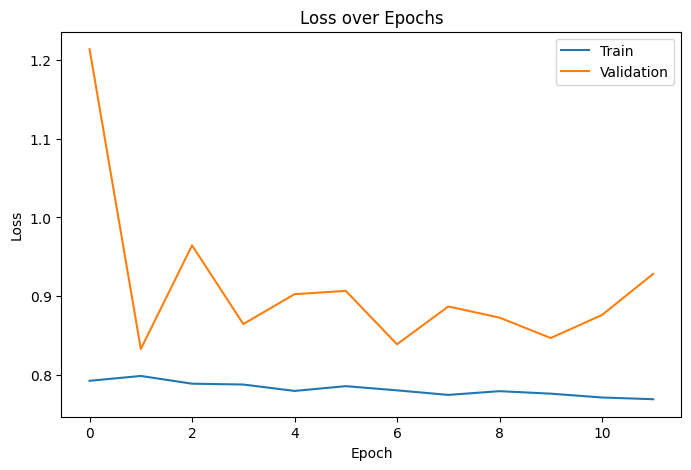

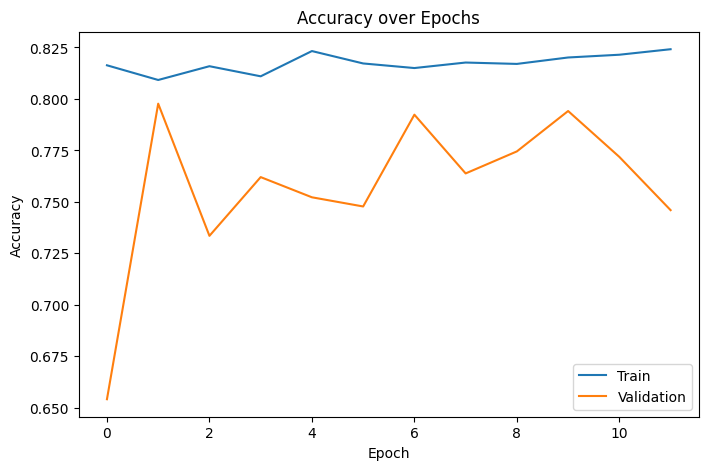

In [ ]:
visualize_modeling_results(history_finetune)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step


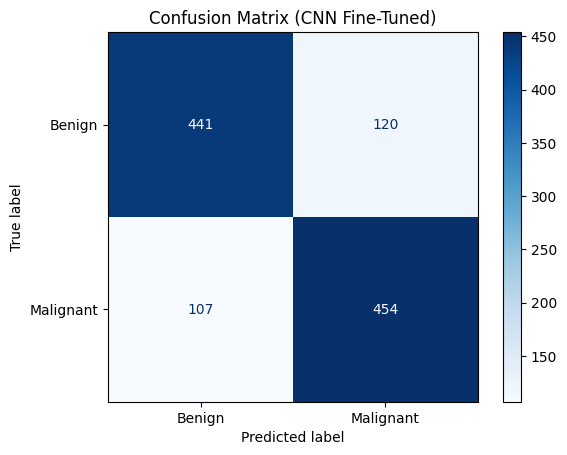

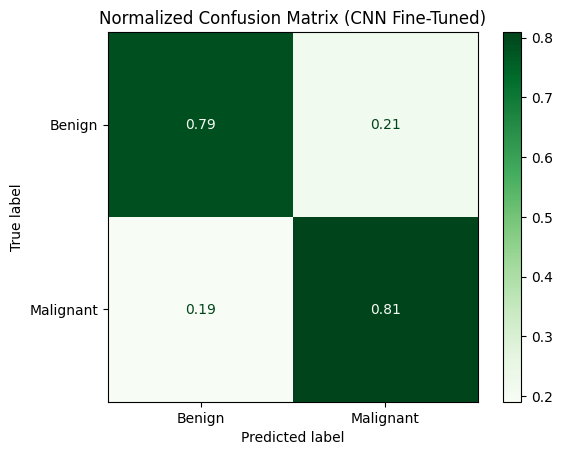

In [ ]:
plot_confusion_matrices_only(
    model, val_generator, title_suffix='(CNN Fine-Tuned)')

In [ ]:
model_finetuned_results = evaluate_model_to_dataframe(
    model, train_generator, val_generator)

In [ ]:
display(model_finetuned_results)

,Loss,Compile_metrics
Train,0.750051,0.829692
Validation,0.833132,0.797683


In [ ]:
save_model_and_results(
    model=model,
    model_name="cnn_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=model_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/cnn_finetuned_results.csv


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.77      0.78      0.77       312
   Malignant       0.77      0.77      0.77       312

    accuracy                           0.77       624
   macro avg       0.77      0.77      0.77       624
weighted avg       0.77      0.77      0.77       624



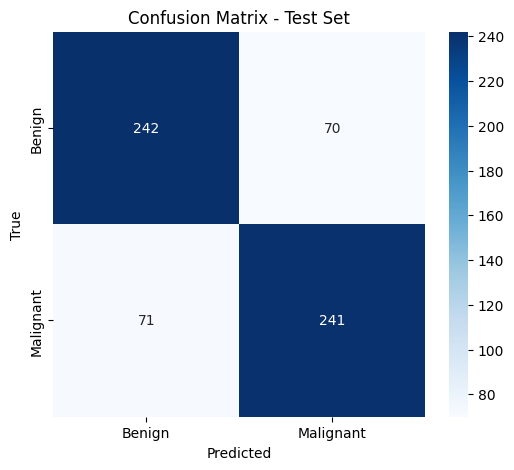

In [ ]:
model = load_model('cnn_finetuned.keras')
evaluate_on_test_set(model, test_generator)

### Xception


In [ ]:
base_model = Xception(weights='imagenet', include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)

output = layers.Dense(1, activation='sigmoid')(x)

xception_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
xception_model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - AUC: 0.6789 - Precision: 0.6216 - Recall: 0.6518 - accuracy: 0.6308 - loss: 0.8508
Epoch 1: val_loss improved from inf to 0.80495, saving model to xception_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 100s 576ms/step - AUC: 0.6791 - Precision: 0.6218 - Recall: 0.6521 - accuracy: 0.6310 - loss: 0.8506 - val_AUC: 0.7900 - val_Precision: 0.7597 - val_Recall: 0.4902 - val_accuracy: 0.6676 - val_loss: 0.8049 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - AUC: 0.7751 - Precision: 0.6998 - Recall: 0.7530 - accuracy: 0.7093 - loss: 0.7528
Epoch 2: val_loss improved from 0.80495 to 0.71631, saving model to xception_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 117s 474ms/step - AUC: 0.7752 - Precision: 0.6998 - Recall: 0.7531 - accuracy: 0.7094 - loss: 0.7527 - val_AUC: 0.8147 - val_Precision: 0.7098 - val_Recall: 0.7718 - val_accuracy: 0.7282 - val_loss: 0.7163 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━

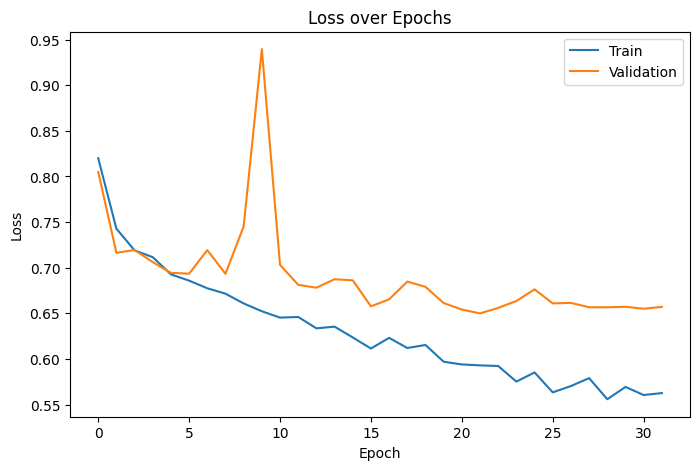

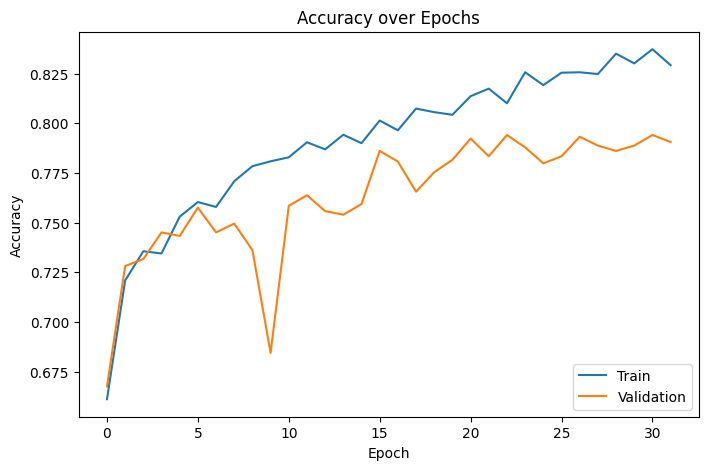

In [ ]:
visualize_modeling_results(history_xception)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step


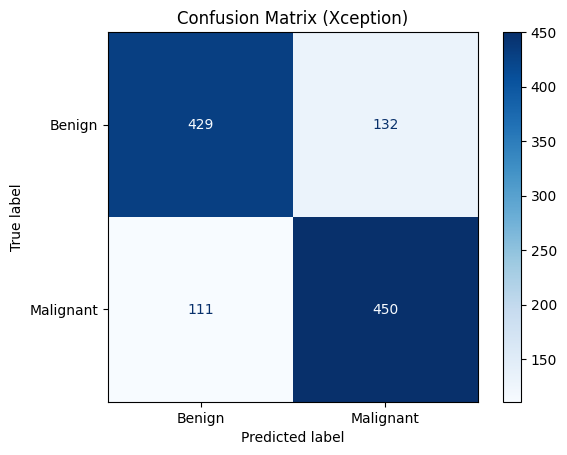

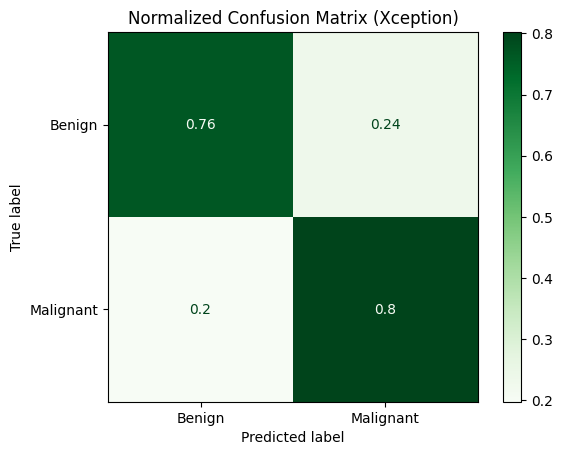

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, title_suffix='(Xception)')

In [ ]:
xception_model_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_model_results)

,Loss,Compile_metrics
Train,0.540622,0.844405
Validation,0.649939,0.783422


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_model_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_model_results.csv


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 546ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.83      0.77      0.80       312
   Malignant       0.79      0.84      0.81       312

    accuracy                           0.81       624
   macro avg       0.81      0.81      0.81       624
weighted avg       0.81      0.81      0.81       624



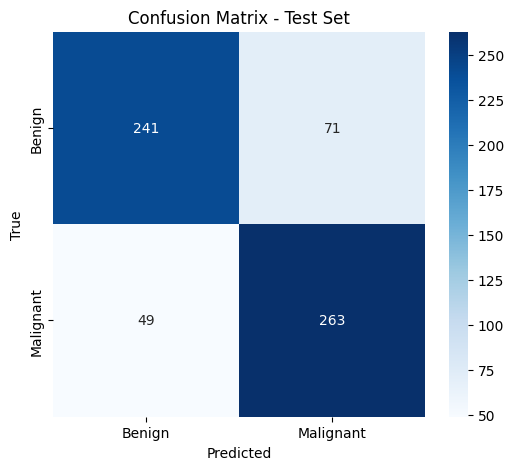

In [ ]:
model = load_model('xception_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
xception_model = load_model("/content/xception_model.keras")

In [ ]:
for layer in xception_model.layers:
    layer.trainable = True

In [ ]:
xception_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("xception_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_xception_finetuned = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - AUC: 0.7547 - Precision: 0.6985 - Recall: 0.6973 - accuracy: 0.6907 - loss: 0.8129
Epoch 1: val_loss improved from inf to 0.77994, saving model to xception_finetuned.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 144s 754ms/step - AUC: 0.7548 - Precision: 0.6985 - Recall: 0.6974 - accuracy: 0.6908 - loss: 0.8128 - val_AUC: 0.8067 - val_Precision: 0.6769 - val_Recall: 0.8627 - val_accuracy: 0.7255 - val_loss: 0.7799 - learning_rate: 1.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - AUC: 0.8078 - Precision: 0.7255 - Recall: 0.7550 - accuracy: 0.7329 - loss: 0.7257
Epoch 2: val_loss improved from 0.77994 to 0.75114, saving model to xception_finetuned.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 648ms/step - AUC: 0.8078 - Precision: 0.7254 - Recall: 0.7549 - accuracy: 0.7329 - loss: 0.7256 - val_AUC: 0.8026 - val_Precision: 0.6798 - val_Recall: 0.8021 - val_accuracy: 0.7121 - val_loss: 0.7511 - learning_rate: 1.0000e-04
Epoch 3/50
141/

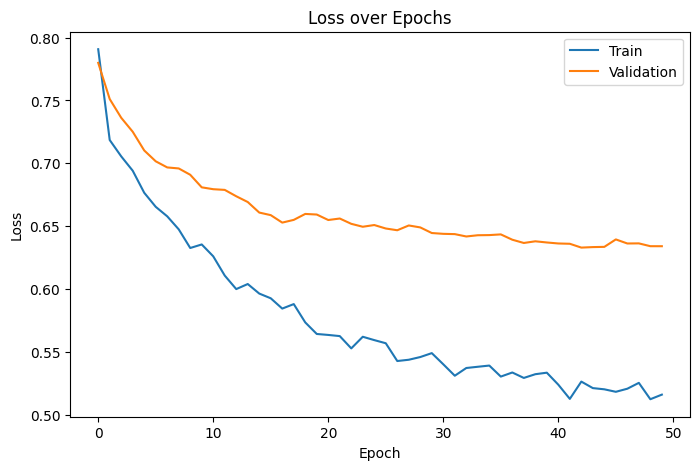

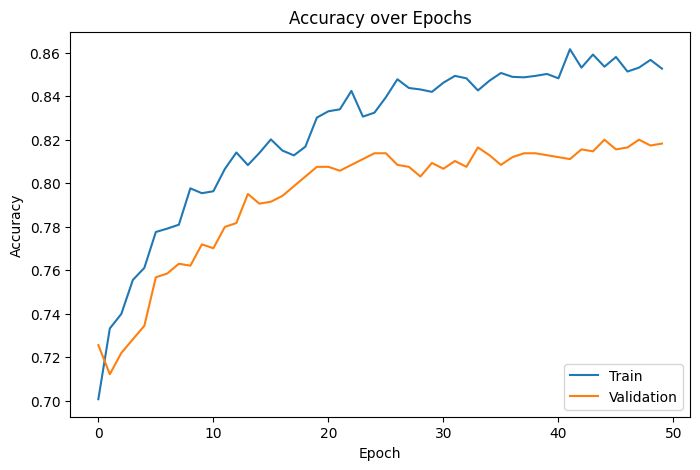

In [ ]:
visualize_modeling_results(history_xception_finetuned)

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step


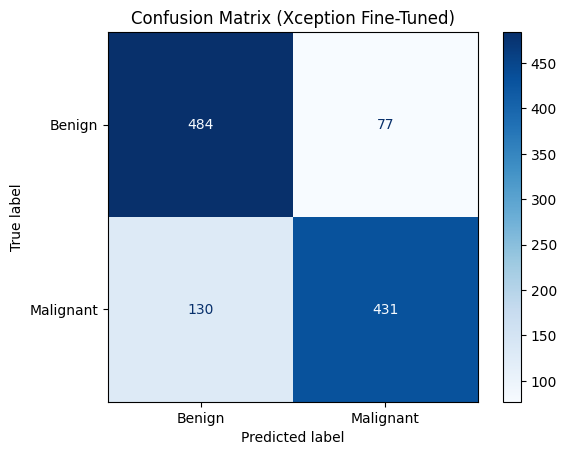

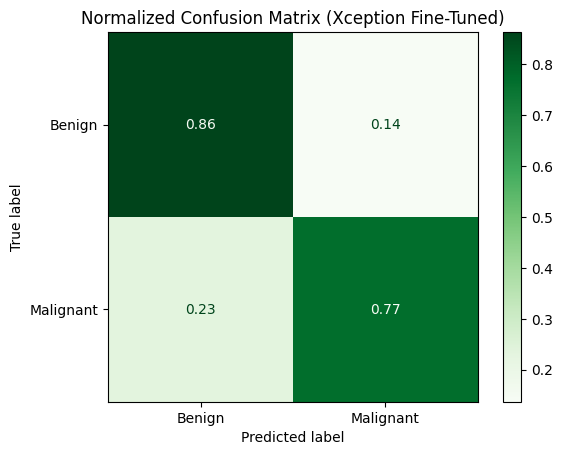

In [ ]:
plot_confusion_matrices_only(
    xception_model, val_generator, title_suffix='(Xception Fine-Tuned)')

In [ ]:
xception_finetuned_results = evaluate_model_to_dataframe(
    xception_model, train_generator, val_generator)

In [ ]:
display(xception_finetuned_results)

,Loss,Compile_metrics
Train,0.466234,0.882078
Validation,0.632963,0.815508


In [ ]:
save_model_and_results(
    model=xception_model,
    model_name="xception_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=xception_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/xception_finetuned_results.csv


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.81      0.84      0.82       312
   Malignant       0.83      0.80      0.82       312

    accuracy                           0.82       624
   macro avg       0.82      0.82      0.82       624
weighted avg       0.82      0.82      0.82       624



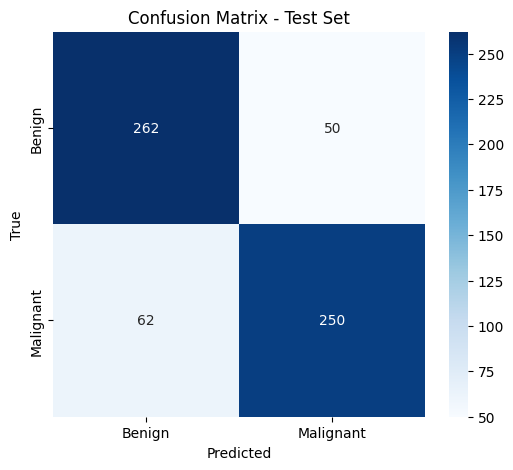

In [ ]:
model = load_model('xception_finetuned.keras')
evaluate_on_test_set(model, test_generator)

### DenseNet121


In [ ]:
base_model = DenseNet121(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.0005))(x)
output = layers.Dense(1, activation='sigmoid')(x)

densenet_model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
densenet_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_model.keras", monitor="val_loss",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1),
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - AUC: 0.7262 - Precision: 0.6562 - Recall: 0.6288 - accuracy: 0.6551 - loss: 0.8149
Epoch 1: val_loss improved from inf to 0.72120, saving model to densenet_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 131s 709ms/step - AUC: 0.7266 - Precision: 0.6566 - Recall: 0.6293 - accuracy: 0.6554 - loss: 0.8145 - val_AUC: 0.8356 - val_Precision: 0.8067 - val_Recall: 0.6471 - val_accuracy: 0.7460 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - AUC: 0.8323 - Precision: 0.7446 - Recall: 0.7670 - accuracy: 0.7494 - loss: 0.6946
Epoch 2: val_loss did not improve from 0.72120
141/141 ━━━━━━━━━━━━━━━━━━━━ 67s 471ms/step - AUC: 0.8323 - Precision: 0.7446 - Recall: 0.7671 - accuracy: 0.7495 - loss: 0.6946 - val_AUC: 0.8460 - val_Precision: 0.8138 - val_Recall: 0.6310 - val_accuracy: 0.7433 - val_loss: 0.7421 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - AUC: 0.8413 - 

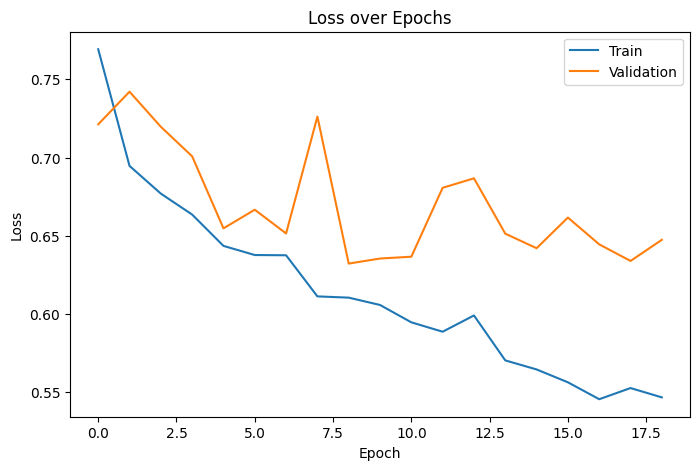

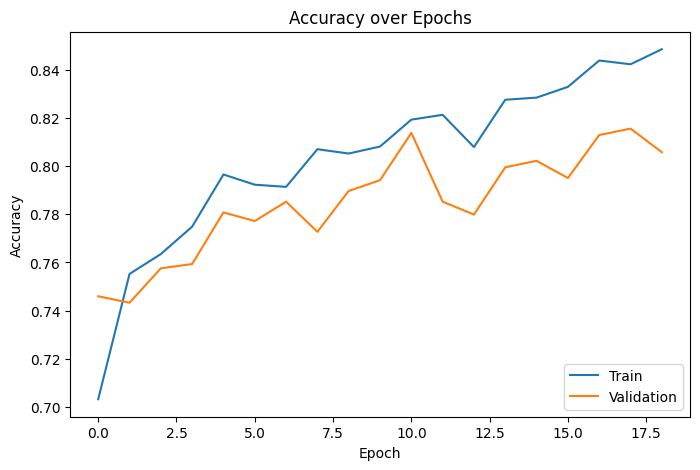

In [ ]:
visualize_modeling_results(history_densenet)

36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step


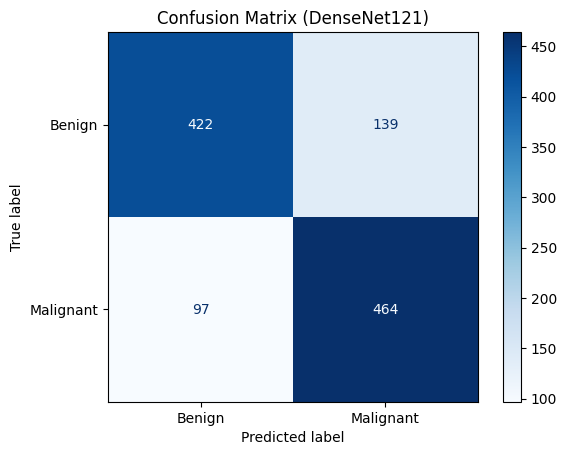

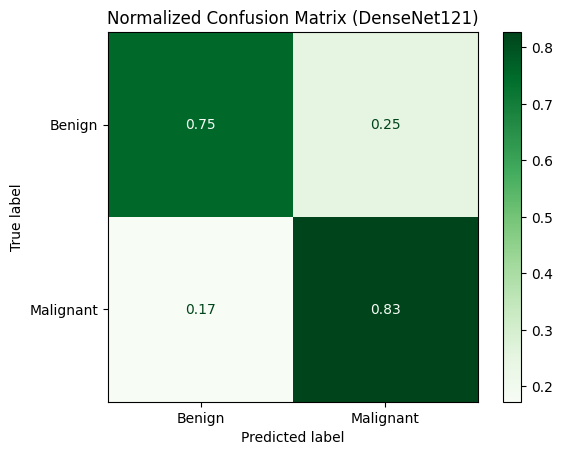

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, title_suffix='(DenseNet121)')

In [ ]:
densenet_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_results)

,Loss,Compile_metrics
Train,0.560618,0.836826
Validation,0.632213,0.789661


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_model",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_model_results.csv


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 850ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.82      0.79      0.81       312
   Malignant       0.80      0.83      0.81       312

    accuracy                           0.81       624
   macro avg       0.81      0.81      0.81       624
weighted avg       0.81      0.81      0.81       624



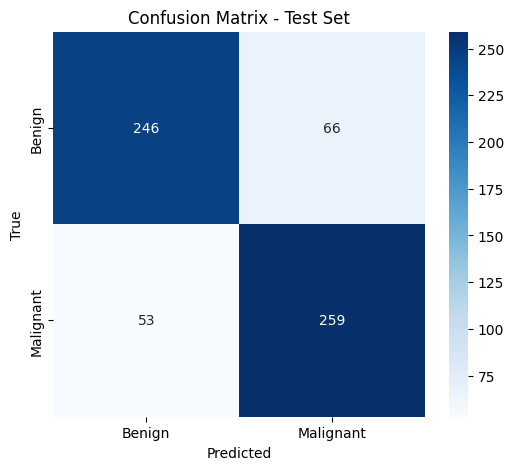

In [ ]:
model = load_model('densenet_model.keras')
evaluate_on_test_set(model, test_generator)

#### Fine-Tuning


In [ ]:
densenet_model = load_model("/content/densenet_model.keras")

In [ ]:
for layer in densenet_model.layers:
    layer.trainable = True

In [ ]:
densenet_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [ ]:
callbacks = [
    ModelCheckpoint("densenet_finetuned.keras",
                    monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10,
                  restore_best_weights=True, verbose=1)
]

In [ ]:
gc.collect()
torch.cuda.empty_cache()
tf.keras.backend.clear_session()

In [ ]:
history_densenet_finetuned = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=int(EPOCHS / 2),
    callbacks=callbacks
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7830 - Precision: 0.7075 - Recall: 0.7175 - accuracy: 0.7090 - loss: 0.7792
Epoch 1: val_loss improved from inf to 0.68155, saving model to densenet_finetuned.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - AUC: 0.7832 - Precision: 0.7077 - Recall: 0.7178 - accuracy: 0.7093 - loss: 0.7789 - val_AUC: 0.8545 - val_Precision: 0.7162 - val_Recall: 0.8681 - val_accuracy: 0.7620 - val_loss: 0.6815 - learning_rate: 1.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - AUC: 0.8764 - Precision: 0.7948 - Recall: 0.8197 - accuracy: 0.8051 - loss: 0.6320
Epoch 2: val_loss improved from 0.68155 to 0.65935, saving model to densenet_finetuned.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 565ms/step - AUC: 0.8764 - Precision: 0.7947 - Recall: 0.8196 - accuracy: 0.8051 - loss: 0.6320 - val_AUC: 0.8618 - val_Precision: 0.7621 - val_Recall: 0.8164 - val_accuracy: 0.7807 - val_loss: 0.6594 - learning_rate: 1.0000e-04
Epoch 3/50
141/141 ━━

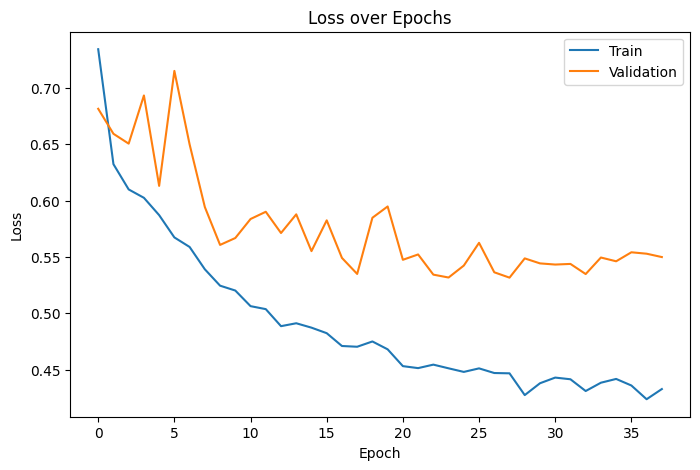

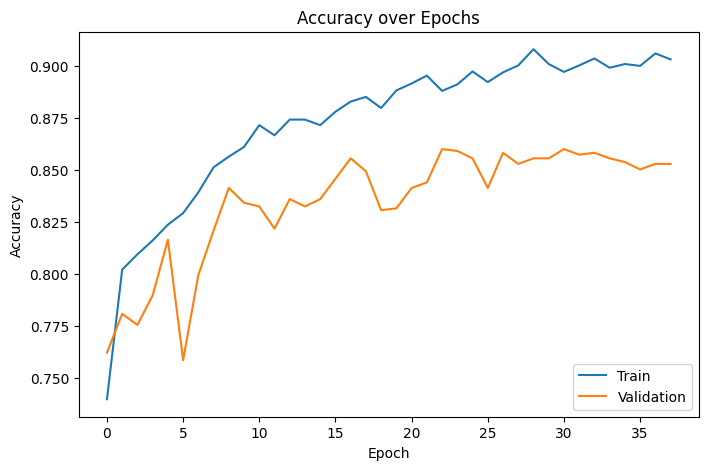

In [ ]:
visualize_modeling_results(history_densenet_finetuned)

36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step


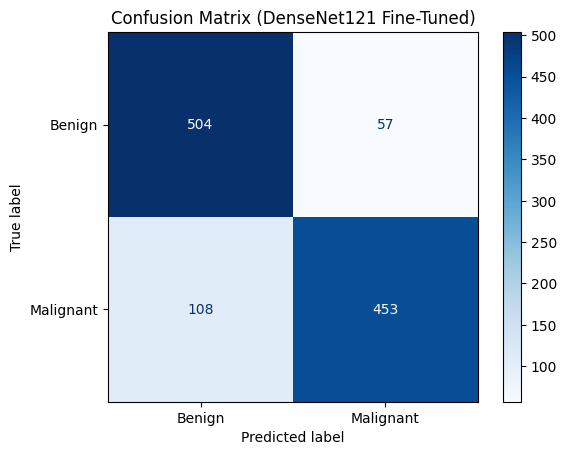

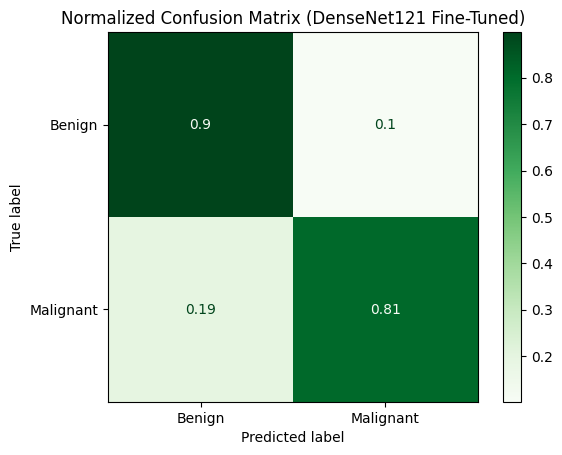

In [ ]:
plot_confusion_matrices_only(
    densenet_model, val_generator, title_suffix='(DenseNet121 Fine-Tuned)')

In [ ]:
densenet_finetuned_results = evaluate_model_to_dataframe(
    densenet_model, train_generator, val_generator)

In [ ]:
display(densenet_finetuned_results)

,Loss,Compile_metrics
Train,0.394005,0.928221
Validation,0.531696,0.852941


In [ ]:
save_model_and_results(
    model=densenet_model,
    model_name="densenet_finetuned",
    model_dir="/content/drive/MyDrive/Skin-Cancer-Detection/models/",
    local_path="/content/",
    results_df=densenet_finetuned_results
)

Saved model to: /content/drive/MyDrive/Skin-Cancer-Detection/models/ and /content/
Saved results CSV to: /content/drive/MyDrive/Skin-Cancer-Detection/models/densenet_finetuned_results.csv


20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 687ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.83      0.87      0.85       312
   Malignant       0.86      0.82      0.84       312

    accuracy                           0.84       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.84      0.84      0.84       624



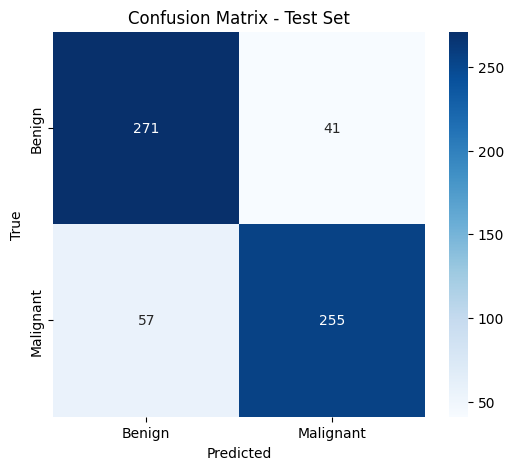

In [ ]:
model = load_model('densenet_finetuned.keras')
evaluate_on_test_set(model, test_generator)

# 3 - Ensemble


In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import ViTForImageClassification

In [25]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 55
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [27]:
model_dir = "/content/drive/MyDrive/Skin-Cancer-Detection/models/binary_models"
csv_path = "/content/binary_classification/binary_classification.csv"
image_root = "/content/binary_classification/binary_images"

In [ ]:
df = pd.read_csv(csv_path)
df['path'] = df['path'].apply(
    lambda x: os.path.join(image_root, os.path.basename(x)))

In [29]:
X = df['path'].values
y = df['benign_malignant'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

In [31]:
df_test = pd.DataFrame({'path': X_test, 'benign_malignant': y_test})

In [ ]:
df_test['benign_malignant'] = df_test['benign_malignant'].map(
    {'benign': 0, 'malignant': 1})
df_test['benign_malignant'] = df_test['benign_malignant'].astype(int)

In [33]:
df_test

,path,benign_malignant
0,/content/binary_classification/binary_images/I...,1
1,/content/binary_classification/binary_images/I...,0
2,/content/binary_classification/binary_images/I...,0
3,/content/binary_classification/binary_images/I...,0
4,/content/binary_classification/binary_images/I...,1
...,...,...
619,/content/binary_classification/binary_images/I...,1
620,/content/binary_classification/binary_images/I...,0
621,/content/binary_classification/binary_images/I...,1
622,/content/binary_classification/binary_images/I...,1


In [34]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='benign_malignant',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 624 validated image filenames.


In [ ]:
from tensorflow.keras import backend as K
import gc


def predict_keras(model_path, generator):
    gc.collect()
    K.clear_session()
    model = tf.keras.models.load_model(model_path)
    preds = model.predict(generator, verbose=1)
    del model
    gc.collect()
    K.clear_session()
    return preds.flatten()

In [ ]:
xception_preds = predict_keras(os.path.join(
    model_dir, "xception_finetuned.keras"), test_generator)
densenet_preds = predict_keras(os.path.join(
    model_dir, "densenet_finetuned.keras"), test_generator)
cnn_preds = predict_keras(os.path.join(
    model_dir, "cnn_finetuned.keras"), test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step


In [37]:
y_true = df_test['benign_malignant'].astype(int).values

## Soft Voting


In [38]:
soft_preds = (xception_preds + densenet_preds + cnn_preds) / 3
soft_final = (soft_preds > 0.5).astype(int)

== Soft Voting Evaluation ==
              precision    recall  f1-score   support

      Benign     0.8406    0.8622    0.8513       312
   Malignant     0.8586    0.8365    0.8474       312

    accuracy                         0.8494       624
   macro avg     0.8496    0.8494    0.8493       624
weighted avg     0.8496    0.8494    0.8493       624



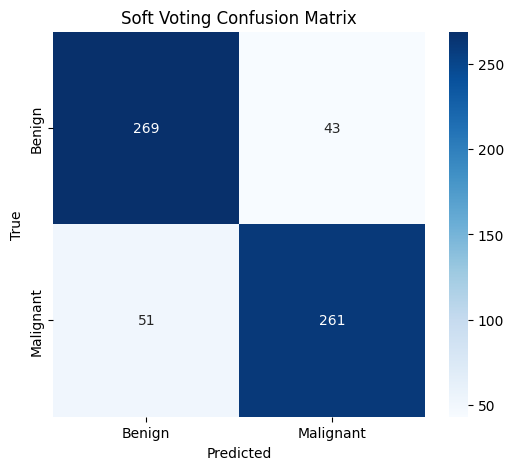

In [ ]:
print("== Soft Voting Evaluation ==")
print(classification_report(y_true, soft_final,
      target_names=["Benign", "Malignant"], digits=4))

cm = confusion_matrix(y_true, soft_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Soft Voting Confusion Matrix")
plt.show()

## Weighted Soft Voting


In [ ]:
from sklearn.metrics import f1_score

best_score = 0
best_weights = (0, 0, 0)

for w1 in np.arange(0, 1.1, 0.1):
    for w2 in np.arange(0, 1.1 - w1, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 < 0:
            continue

        weighted_preds = (
            w1 * densenet_preds +
            w2 * xception_preds +
            w3 * cnn_preds
        )

        pred_labels = (weighted_preds > 0.5).astype(int)
        score = f1_score(y_true, pred_labels)

        if score > best_score:
            best_score = score
            best_weights = (w1, w2, w3)

print("Best F1 Score:", best_score)
print("Best Weights: DenseNet=%.4f, Xception=%.4f, CNN=%.4f" % best_weights)

Best F1 Score: 0.8557692307692307
Best Weights: DenseNet=0.3000, Xception=0.3000, CNN=0.4000


In [41]:
weighted_preds = (
    0.3 * densenet_preds +
    0.3 * xception_preds +
    0.4 * cnn_preds
)
weighted_final = (weighted_preds > 0.5).astype(int)

== Weighted Soft Voting ==
              precision    recall  f1-score   support

           0     0.8558    0.8558    0.8558       312
           1     0.8558    0.8558    0.8558       312

    accuracy                         0.8558       624
   macro avg     0.8558    0.8558    0.8558       624
weighted avg     0.8558    0.8558    0.8558       624



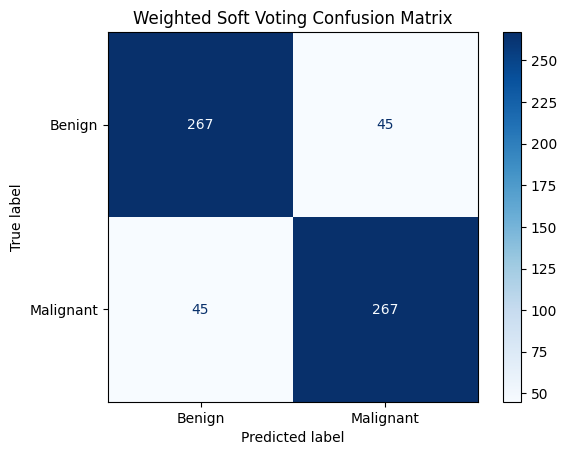

In [ ]:
print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_true, weighted_final), display_labels=[
                       "Benign", "Malignant"]).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()

# 4 - Final Ensemble Decision


For the binary classification task of identifying benign vs malignant skin lesions, we employed a weighted soft voting ensemble approach integrating the predictions of three independently trained models: DenseNet121, Xception, and a custom CNN.

Each model was trained using identical augmentation and preprocessing strategies to ensure uniform input representation across the ensemble. After systematic evaluation, the following weight combination delivered the most balanced performance:

- DenseNet121: 30%

- Xception: 30%

- CNN: 40%

This final ensemble achieved:

- Accuracy: 85.58%

- Macro F1-score: 0.8558

- Precision (Benign/Malignant): 0.8558 / 0.8558

- Recall (Benign/Malignant): 0.8558 / 0.8558

The confusion matrix indicates a highly symmetric performance, with 267 correct predictions for each class and only 45 misclassifications per class, demonstrating the model’s robustness and balanced treatment of both benign and malignant cases.

This ensemble strategy was selected as the final inference model for the binary decision stage in our melanoma classification pipeline.


== Weighted Soft Voting ==
              precision    recall  f1-score   support

           0     0.8558    0.8558    0.8558       312
           1     0.8558    0.8558    0.8558       312

    accuracy                         0.8558       624
   macro avg     0.8558    0.8558    0.8558       624
weighted avg     0.8558    0.8558    0.8558       624



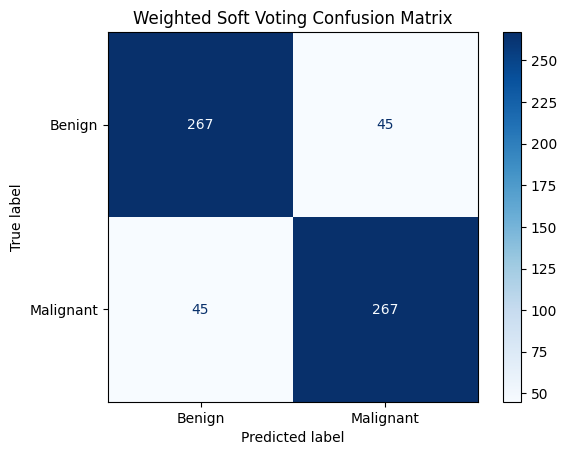

In [ ]:
weighted_preds = (
    0.3 * densenet_preds +
    0.3 * xception_preds +
    0.4 * cnn_preds
)
weighted_final = (weighted_preds > 0.5).astype(int)

print("== Weighted Soft Voting ==")
print(classification_report(y_true, weighted_final, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_true, weighted_final), display_labels=[
                       "Benign", "Malignant"]).plot(cmap="Blues")
plt.title("Weighted Soft Voting Confusion Matrix")
plt.show()